The notebook contains the final results for all the clustering algorithms , please refer to clustering_analysis.ipynb, clustering_analysis_v2.ipynb, unsupervised.ipynb, ml_unsupervised.ipynb, ml_unsupervised_hdbscan.ipynb for detailed list of experiements

# Load Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import umap
import hdbscan
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA

sys.path.append('../src')

/Users/utkarshmaheshwari/opt/anaconda3/envs/nutrilens/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from data_loading import *
from eda import *
from data_cleaning import *
from k_means import *
from cluster_evaluation import *
from cluster_interpretation import *
from save_models import *
from recommendation_pipeline import *

# Load Data

In [5]:
emb_path = "../data/analysis_data/embeddings.npy"
meta_path = "../data/analysis_data/only_english.csv"

embeddings_numpy_arr = np.load(emb_path)
embeddings_df = pd.DataFrame(embeddings_numpy_arr)

only_english = read_file(meta_path, seperator=",")
only_english = only_english[['product_name', 'categories_tags', 'nova_group', 'ingredients_text', 'ingredient_count', 'additives_n', 'nutriscore_score', 'monounsaturated-fat_100g','sugars_100g','polyunsaturated-fat_100g','sugar_fiber_ratio','carbohydrates_100g','fiber_100g','saturated-fat_100g','sodium_per_calorie','code', 'additive_density', 'allergens_en']]

cluster_df = merge_data_frames(df1=only_english, df2 = embeddings_df)
print(cluster_df.shape)
cluster_df
# NAN values are kept for nutritional information to avoid dropping a lot of rows

Shape of the data: (272809, 18)

Columns loaded:
['code', 'product_name', 'categories_tags', 'ingredients_text', 'ingredient_count', 'additives_n', 'additive_density', 'nutriscore_score', 'monounsaturated-fat_100g', 'sugars_100g', 'polyunsaturated-fat_100g', 'sugar_fiber_ratio', 'carbohydrates_100g', 'fiber_100g', 'saturated-fat_100g', 'sodium_per_calorie', 'allergens_en', 'nova_group']
(272809, 402)


,product_name,categories_tags,nova_group,ingredients_text,ingredient_count,additives_n,nutriscore_score,monounsaturated-fat_100g,sugars_100g,polyunsaturated-fat_100g,...,374,375,376,377,378,379,380,381,382,383
0,Hershey’s Syrup,"en:beverages-and-beverages-preparations,en:bev...",1,organ defat hemp seed powder certifi organ qua...,1,0.0,NaN,0.0,6.0,0.0,...,-0.021125,0.020245,0.064699,-0.034334,0.051692,-0.022212,0.006391,0.025445,0.077194,-0.048097
1,Vanille-Erdbeer-Cocktail,NaN,4,sunflow seed butter roast sunflow kernel dri c...,30,4.0,NaN,0.0,0.0,0.0,...,-0.002987,0.008882,0.038631,-0.054230,0.064427,-0.033297,-0.031501,-0.038130,-0.006603,-0.042481
2,Naturelo,NaN,4,methylcellulos color preserv flavong ount per ...,5,1.0,NaN,0.0,0.0,0.0,...,-0.073252,0.015455,0.074647,0.074792,0.046393,-0.074582,-0.020494,-0.082925,0.045365,-0.041050
3,Prebiotic Fiber Gummies,"en:snacks,en:sweet-snacks,en:confectioneries,e...",4,chicori root fiber water pectin agar agar tapi...,11,6.0,NaN,0.0,0.0,0.0,...,0.057201,0.003271,0.063289,0.023518,0.026960,0.024571,-0.015965,-0.011356,0.067122,-0.004868
4,Irish Sea Moss,NaN,4,irish sea moss extract chondru crispu hypromel...,3,2.0,NaN,0.0,0.0,0.0,...,-0.035997,0.041002,0.092975,-0.031187,0.005940,-0.003002,-0.091133,-0.081211,0.068467,0.013320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272804,Puffs Strawberry Apple,en:baby-foods,4,rice flour whole wheat flour wheat starch cane...,15,3.0,NaN,0.0,0.0,0.0,...,-0.019223,0.029651,0.018347,-0.029234,0.029225,-0.041874,-0.028947,-0.003734,0.005282,-0.064536
272805,Cuban Style Citrus Garlic Bowl,"en:frozen-foods,en:meals,en:combination-meals,...",4,cook season rice water long grain rice turmer ...,38,0.0,NaN,0.0,0.0,0.0,...,-0.042006,-0.014731,0.053876,0.071181,0.054937,-0.058037,-0.013861,-0.006707,-0.062483,0.034017
272806,Genuine,en:protein-drink,4,water milk protein isol calcium casein contain...,23,7.0,NaN,0.0,0.0,0.0,...,0.012150,0.009706,0.047013,-0.058524,0.048262,-0.028935,-0.028030,-0.044621,0.104435,0.004375
272807,noodle,NaN,4,enrich wheat flour wheat flour niacin reduc ir...,56,8.0,NaN,0.0,0.0,0.0,...,-0.062486,0.035107,0.031800,0.012739,0.074910,-0.008585,-0.026089,-0.029522,0.031500,-0.006527


# Data Preprocessing

124 categories are more than 90% out of 5477
5353 categories are less than 10% of the entire data and should be removed


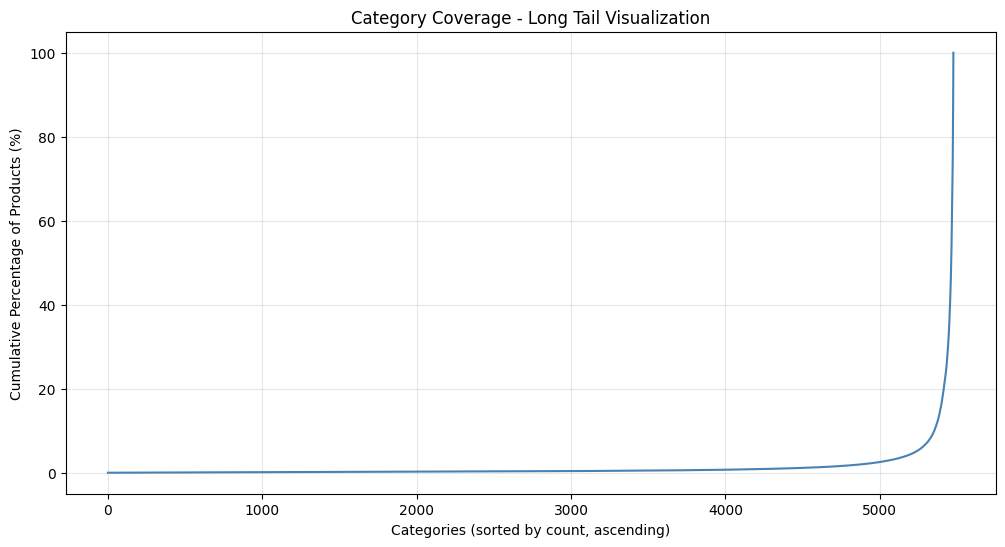

In [17]:
top_n_categories = find_tail(cluster_df, 10)
top_n_categories = [i for i in top_n_categories if i not in ['en:null', 'en:undefined']]

In [18]:
cluster_df_dist_cats = filter_if_one_present(cluster_df, top_n_categories)

In [19]:
demo_df, cluster_df_dist_cats = create_demo_data(cluster_df_dist_cats)

# Dimension Reduction

In [21]:
cluster_df_dist_cats_emb, cluster_df_dist_cats_meta = extract_embeddings(cluster_df_dist_cats)
cluster_df_dist_cats_emb_umap_150, reducer = reduce_dimensions_umap(cluster_df_dist_cats_emb, n_components=150, random_state=42)

Reducing from 384 to 150 dimensions using UMAP
UMAP(angular_rp_forest=True, metric='cosine', n_components=150, n_jobs=1, random_state=42, verbose=True)
Mon Dec 22 16:08:16 2025 Construct fuzzy simplicial set
Mon Dec 22 16:08:16 2025 Finding Nearest Neighbors
Mon Dec 22 16:08:16 2025 Building RP forest with 12 trees


/Users/utkarshmaheshwari/opt/anaconda3/envs/nutrilens/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Mon Dec 22 16:08:20 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Mon Dec 22 16:08:28 2025 Finished Nearest Neighbor Search
Mon Dec 22 16:08:30 2025 Construct embedding


Epochs completed:   1%|            2/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  10%| █          21/200 [00:05]

	completed  20  /  200 epochs


Epochs completed:  20%| ██         41/200 [00:10]

	completed  40  /  200 epochs


Epochs completed:  30%| ███        61/200 [00:15]

	completed  60  /  200 epochs


Epochs completed:  40%| ████       81/200 [00:20]

	completed  80  /  200 epochs


Epochs completed:  50%| █████      101/200 [00:25]

	completed  100  /  200 epochs


Epochs completed:  60%| ██████     121/200 [00:30]

	completed  120  /  200 epochs


Epochs completed:  70%| ███████    141/200 [00:36]

	completed  140  /  200 epochs


Epochs completed:  80%| ████████   161/200 [00:40]

	completed  160  /  200 epochs


Epochs completed:  90%| █████████  181/200 [00:45]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:49]

Mon Dec 22 16:09:52 2025 Finished embedding
UMAP reduction complete: (21676, 150)


Reducing from 383 to 2 dimensions using UMAP
UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=42, verbose=True)
Tue Dec  2 17:44:52 2025 Construct fuzzy simplicial set
Tue Dec  2 17:44:52 2025 Finding Nearest Neighbors
Tue Dec  2 17:44:52 2025 Building RP forest with 12 trees


/Users/utkarshmaheshwari/opt/anaconda3/envs/nutrilens/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Tue Dec  2 17:44:53 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Tue Dec  2 17:44:55 2025 Finished Nearest Neighbor Search
Tue Dec  2 17:44:55 2025 Construct embedding


/Users/utkarshmaheshwari/opt/anaconda3/envs/nutrilens/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/utkarshmaheshwari/opt/anaconda3/envs/nutrilens/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/utkarshmaheshwari/opt/anaconda3/envs/nutrilens/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
Epochs completed:   3%| ▎

	completed  0  /  200 epochs


Epochs completed:  12%| █▏         23/200 [00:01]

	completed  20  /  200 epochs


Epochs completed:  22%| ██▏        43/200 [00:03]

	completed  40  /  200 epochs


Epochs completed:  32%| ███▏       63/200 [00:04]

	completed  60  /  200 epochs


Epochs completed:  42%| ████▏      83/200 [00:06]

	completed  80  /  200 epochs


Epochs completed:  52%| █████▏     103/200 [00:07]

	completed  100  /  200 epochs


Epochs completed:  62%| ██████▏    123/200 [00:09]

	completed  120  /  200 epochs


Epochs completed:  72%| ███████▏   143/200 [00:10]

	completed  140  /  200 epochs


Epochs completed:  82%| ████████▏  163/200 [00:12]

	completed  160  /  200 epochs


Epochs completed:  92%| █████████▏ 183/200 [00:13]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:15]


Tue Dec  2 17:45:16 2025 Finished embedding
UMAP reduction complete: (21695, 2)


/var/folders/7j/pj2q5pdx6g373n0pxkk0xd4r0000gn/T/ipykernel_33868/2585839495.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/var/folders/7j/pj2q5pdx6g373n0pxkk0xd4r0000gn/T/ipykernel_33868/2585839495.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


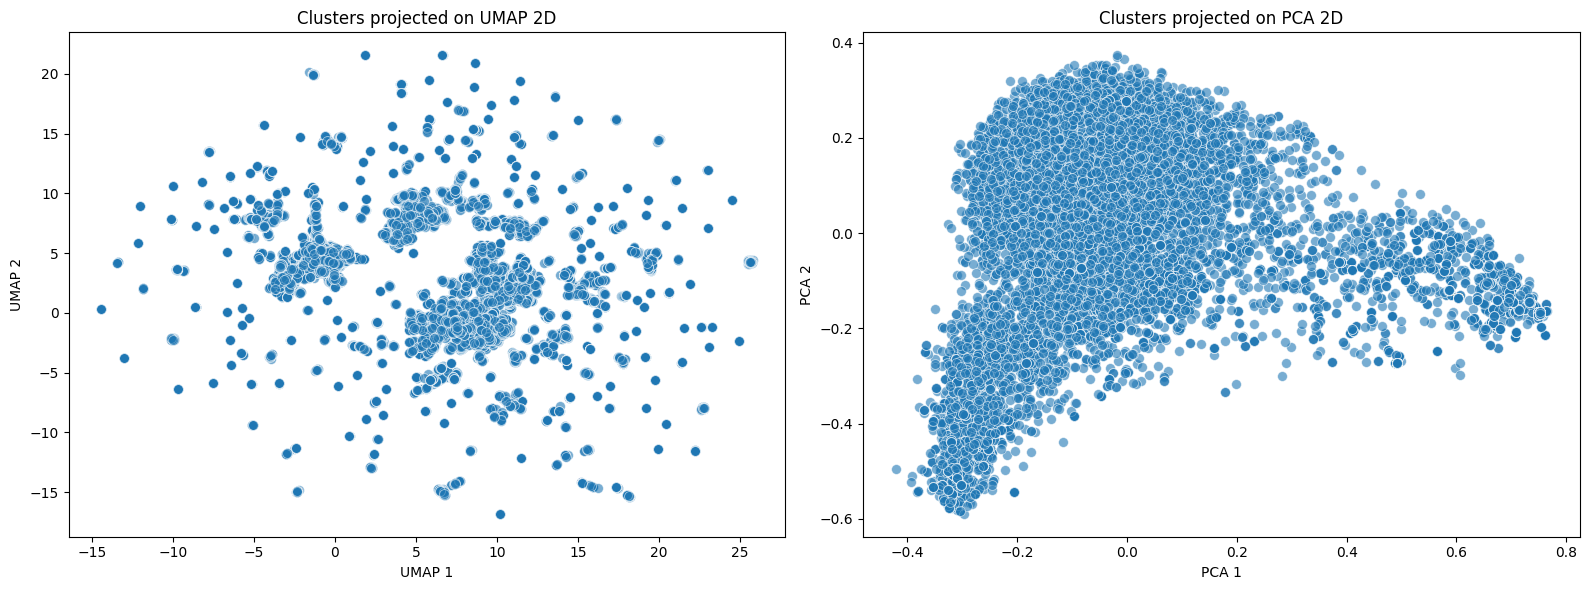

In [8]:
# UMAP provides more seperable data as comapred to PCA as visualised in 2-D space


X_umap_2d, _ = reduce_dimensions_umap(cluster_df_dist_cats_emb, n_components=2, random_state=42)
pca_2d = PCA(n_components=2, random_state=42).fit_transform(cluster_df_dist_cats_emb)

# # Use your best KMeans labels
# labels_best = labels  # from k=16 KMeans on 150D UMAP embeddings

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# UMAP 2D
sns.scatterplot(
    x=X_umap_2d[:,0], y=X_umap_2d[:,1],
    palette='tab20', alpha=0.6, s=50,
    ax=axes[0]
)
axes[0].set_title("Clusters projected on UMAP 2D")
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")

# PCA 2D
sns.scatterplot(
    x=pca_2d[:,0], y=pca_2d[:,1],
    palette='tab20', alpha=0.6, s=50,
    ax=axes[1]
)
axes[1].set_title("Clusters projected on PCA 2D")
axes[1].set_xlabel("PCA 1")
axes[1].set_ylabel("PCA 2")

plt.tight_layout()
plt.show()


# Model Training and Predictions

### Training multiple models (refer clustering_analysis.ipynb for details)

In [72]:
Ks = range(2, 21, 1) 
results_150_dims = {
    "k_value": [],
    "inertia_kmeans": [],
    "silhouette_kmeans": [],
    "inertia_gmm": [],
    "silhouette_gmm": [],
    "silhouette_hierarchial": []
}

X = cluster_df_dist_cats_emb_umap_150 

for k in Ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans_labels = kmeans.fit_predict(X)
    inertia_k = kmeans.inertia_
    sil_k = silhouette_score(X, kmeans_labels)

    gmm = GaussianMixture(n_components=k, covariance_type="diag", reg_covar=1e-3 ,random_state=42) #diagonal covariance for faster convergence
    gmm_labels = gmm.fit_predict(X)
    inertia_gmm = -gmm.score(X) * len(X)
    sil_gmm = silhouette_score(X, gmm_labels)

    hier = AgglomerativeClustering(n_clusters=k, linkage="ward")
    hier_labels = hier.fit_predict(X)
    sil_hier = silhouette_score(X, hier_labels)

    results_150_dims["k_value"].append(k)

    results_150_dims["inertia_kmeans"].append(inertia_k)
    results_150_dims["silhouette_kmeans"].append(sil_k)

    results_150_dims["inertia_gmm"].append(inertia_gmm)
    results_150_dims["silhouette_gmm"].append(sil_gmm)

    results_150_dims["silhouette_hierarchial"].append(sil_hier)
    print(f"Calculations for {k} clusters completed")


Calculations for 2 clusters completed
Calculations for 3 clusters completed
Calculations for 4 clusters completed
Calculations for 5 clusters completed
Calculations for 6 clusters completed
Calculations for 7 clusters completed
Calculations for 8 clusters completed
Calculations for 9 clusters completed
Calculations for 10 clusters completed
Calculations for 11 clusters completed
Calculations for 12 clusters completed
Calculations for 13 clusters completed
Calculations for 14 clusters completed
Calculations for 15 clusters completed
Calculations for 16 clusters completed
Calculations for 17 clusters completed
Calculations for 18 clusters completed
Calculations for 19 clusters completed
Calculations for 20 clusters completed


In [10]:

# Assuming X and Ks are already defined:
# X = cluster_df_dist_cats_emb_umap_150
Ks = range(2, 21, 1) 
X = cluster_df_dist_cats_emb_umap_150 

results_150_dims = {
    "k_value": [],
    "inertia_kmeans": [],
    "silhouette_kmeans": [],
    "davies_bouldin_kmeans": [], # ADDED
    "calinski_harabasz_kmeans": [], # ADDED
    
    "inertia_gmm": [],
    "silhouette_gmm": [],
    "davies_bouldin_gmm": [], # ADDED
    "calinski_harabasz_gmm": [], # ADDED
    
    "silhouette_hierarchial": [],
    "davies_bouldin_hierarchial": [], # ADDED
    "calinski_harabasz_hierarchial": [] # ADDED
}

# --- Clustering and Evaluation Loop ---
for k in Ks:
    # 1. K-MEANS
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans_labels = kmeans.fit_predict(X)
    inertia_k = kmeans.inertia_
    sil_k = silhouette_score(X, kmeans_labels)
    db_k = davies_bouldin_score(X, kmeans_labels) # DB Score
    ch_k = calinski_harabasz_score(X, kmeans_labels) # CH Score

    # 2. GAUSSIAN MIXTURE MODEL (GMM)
    gmm = GaussianMixture(n_components=k, covariance_type="diag", reg_covar=1e-3 ,random_state=42)
    gmm_labels = gmm.fit_predict(X)
    inertia_gmm = -gmm.score(X) * len(X)
    sil_gmm = silhouette_score(X, gmm_labels)
    db_gmm = davies_bouldin_score(X, gmm_labels) # DB Score
    ch_gmm = calinski_harabasz_score(X, gmm_labels) # CH Score

    # 3. HIERARCHICAL CLUSTERING
    hier = AgglomerativeClustering(n_clusters=k, linkage="ward")
    hier_labels = hier.fit_predict(X)
    sil_hier = silhouette_score(X, hier_labels)
    db_hier = davies_bouldin_score(X, hier_labels) # DB Score
    ch_hier = calinski_harabasz_score(X, hier_labels) # CH Score

    # --- Append Results ---
    results_150_dims["k_value"].append(k)

    # K-Means
    results_150_dims["inertia_kmeans"].append(inertia_k)
    results_150_dims["silhouette_kmeans"].append(sil_k)
    results_150_dims["davies_bouldin_kmeans"].append(db_k)
    results_150_dims["calinski_harabasz_kmeans"].append(ch_k)

    # GMM
    results_150_dims["inertia_gmm"].append(inertia_gmm)
    results_150_dims["silhouette_gmm"].append(sil_gmm)
    results_150_dims["davies_bouldin_gmm"].append(db_gmm)
    results_150_dims["calinski_harabasz_gmm"].append(ch_gmm)

    # Hierarchical
    results_150_dims["silhouette_hierarchial"].append(sil_hier)
    results_150_dims["davies_bouldin_hierarchial"].append(db_hier)
    results_150_dims["calinski_harabasz_hierarchial"].append(ch_hier)
    
    print(f"Calculations for {k} clusters completed")

Calculations for 2 clusters completed
Calculations for 3 clusters completed
Calculations for 4 clusters completed
Calculations for 5 clusters completed
Calculations for 6 clusters completed
Calculations for 7 clusters completed
Calculations for 8 clusters completed
Calculations for 9 clusters completed
Calculations for 10 clusters completed
Calculations for 11 clusters completed
Calculations for 12 clusters completed
Calculations for 13 clusters completed
Calculations for 14 clusters completed
Calculations for 15 clusters completed
Calculations for 16 clusters completed
Calculations for 17 clusters completed
Calculations for 18 clusters completed
Calculations for 19 clusters completed
Calculations for 20 clusters completed


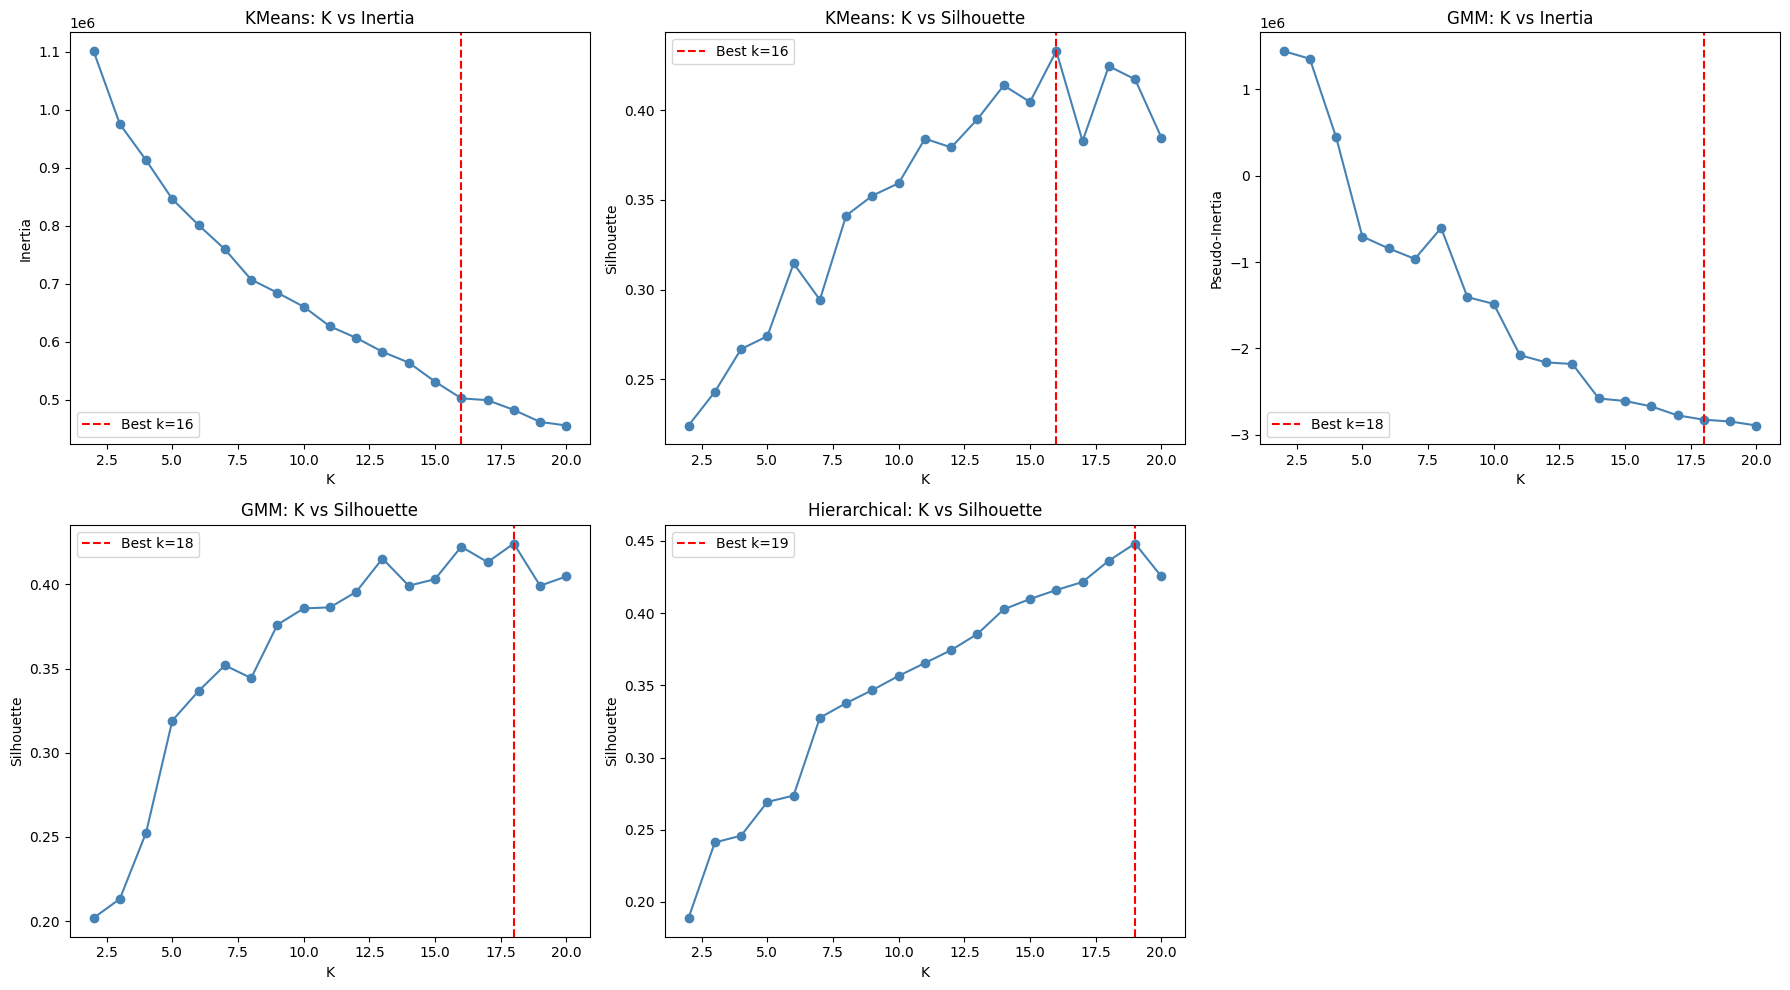

In [11]:
df = pd.DataFrame(results_150_dims).copy()
best_k_kmeans = df.loc[df['silhouette_kmeans'].idxmax(), 'k_value']
best_k_gmm = df.loc[df['silhouette_gmm'].idxmax(), 'k_value']
best_k_hier = df.loc[df['silhouette_hierarchial'].idxmax(), 'k_value']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()


axes[0].plot(df['k_value'], df['inertia_kmeans'], marker='o', color='steelblue')
axes[0].axvline(best_k_kmeans, color='red', linestyle='--', label=f'Best k={best_k_kmeans}')
axes[0].set_title('KMeans: K vs Inertia')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Inertia')
axes[0].legend()


axes[1].plot(df['k_value'], df['silhouette_kmeans'], marker='o', color='steelblue')
axes[1].axvline(best_k_kmeans, color='red', linestyle='--', label=f'Best k={best_k_kmeans}')
axes[1].set_title('KMeans: K vs Silhouette')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Silhouette')
axes[1].legend()


axes[2].plot(df['k_value'], df['inertia_gmm'], marker='o', color='steelblue')
axes[2].axvline(best_k_gmm, color='red', linestyle='--', label=f'Best k={best_k_gmm}')
axes[2].set_title('GMM: K vs Inertia')
axes[2].set_xlabel('K')
axes[2].set_ylabel('Pseudo-Inertia')
axes[2].legend()


axes[3].plot(df['k_value'], df['silhouette_gmm'], marker='o', color='steelblue')
axes[3].axvline(best_k_gmm, color='red', linestyle='--', label=f'Best k={best_k_gmm}')
axes[3].set_title('GMM: K vs Silhouette')
axes[3].set_xlabel('K')
axes[3].set_ylabel('Silhouette')
axes[3].legend()


axes[4].plot(df['k_value'], df['silhouette_hierarchial'], marker='o', color='steelblue')
axes[4].axvline(best_k_hier, color='red', linestyle='--', label=f'Best k={best_k_hier}')
axes[4].set_title('Hierarchical: K vs Silhouette')
axes[4].set_xlabel('K')
axes[4].set_ylabel('Silhouette')
axes[4].legend()


axes[5].axis('off')

plt.tight_layout()
plt.show()


In [12]:
pd.DataFrame(results_150_dims)

,k_value,inertia_kmeans,silhouette_kmeans,davies_bouldin_kmeans,calinski_harabasz_kmeans,inertia_gmm,silhouette_gmm,davies_bouldin_gmm,calinski_harabasz_gmm,silhouette_hierarchial,davies_bouldin_hierarchial,calinski_harabasz_hierarchial
0,2,1.100819e+06,0.224356,2.286441,3058.020752,1444146.625,0.201859,1.512173,2740.484375,0.188855,2.038634,2984.660400
1,3,9.751579e+05,0.243075,1.295727,3123.614746,1354851.000,0.213179,1.162562,1713.076294,0.241171,1.262020,3108.296631
2,4,9.128508e+05,0.266918,1.090864,2717.948486,447990.250,0.252541,1.101384,2365.382080,0.245878,1.830150,2753.236084
3,5,8.458029e+05,0.274077,1.515817,2629.806396,-704153.875,0.319154,2.728874,2078.249512,0.269214,1.519333,2614.792480
4,6,8.011456e+05,0.314599,2.020068,2462.816650,-841997.875,0.336709,2.387497,2084.364014,0.273667,1.270624,2539.164062
5,7,7.594216e+05,0.294387,1.425658,2363.599609,-963013.500,0.351963,2.131680,2092.073242,0.327573,1.769595,2497.740967
6,8,7.073328e+05,0.341261,1.615656,2403.189209,-605058.625,0.344396,1.678037,1972.376343,0.337683,1.713383,2397.795654
7,9,6.846544e+05,0.352364,1.551894,2262.135498,-1406407.875,0.376087,1.805187,1979.540405,0.346713,1.464340,2321.252197
8,10,6.605984e+05,0.359293,1.545534,2171.654053,-1484402.000,0.385763,1.674901,1933.008911,0.356557,1.453287,2272.962158
9,11,6.267604e+05,0.384111,1.786342,2176.985840,-2079377.375,0.386369,2.188863,2080.107910,0.365450,1.271066,2239.597656


In [13]:
pd.DataFrame(results_150_dims).to_csv("updated_experiment_results.csv")

Text(0, 0.5, 'Inertia (Within-Cluster Sum of Squares)')

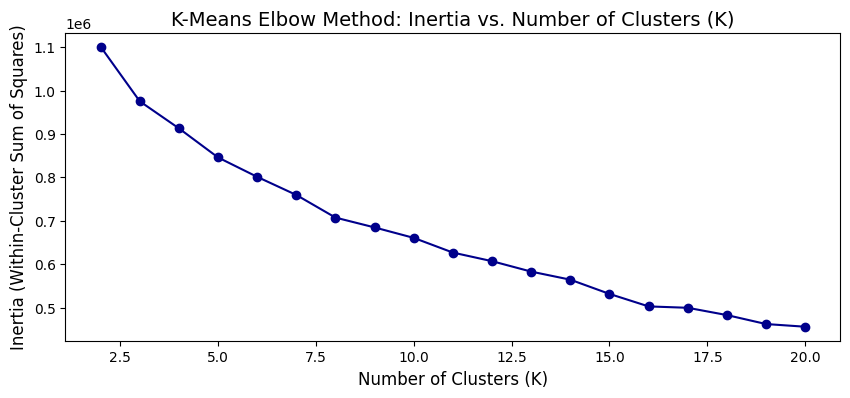

In [17]:
plt.figure(figsize=(10, 4)) 

# Plot the inertia_kmeans vs. k_value
plt.plot(
    results_150_dims['k_value'], 
    results_150_dims['inertia_kmeans'], 
    marker='o', 
    linestyle='-', 
    color='darkblue'
)

# Label the chart elements
plt.title('K-Means Elbow Method: Inertia vs. Number of Clusters (K)', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
# plt.grid(False, linestyle='--', alpha=0.6)

In [32]:
np.random.seed(42)
rnd_idx = np.random.choice(cluster_df_dist_cats.index, 20)
print(rnd_idx)
demo_df = cluster_df_dist_cats.loc[rnd_idx]
cluster_df_dist_cats = cluster_df_dist_cats.drop(index=rnd_idx)

print(demo_df.shape)
print(cluster_df_dist_cats.shape)

[199512   5509  82564 271581 156394 151094  96775 212300  68777 182734
 151651 202325 118011  20236   4973  31624  79701  75499  98286 222159]
(20, 399)
(21675, 399)


### Final Model

In [22]:
X = cluster_df_dist_cats_emb_umap_150
k=16
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
labels = kmeans.fit_predict(cluster_df_dist_cats_emb_umap_150)

#store values
best_k_val = k
in_sc = kmeans.inertia_
sh_sc = silhouette_score(cluster_df_dist_cats_emb_umap_150, labels)
db_sc = davies_bouldin_score(cluster_df_dist_cats_emb_umap_150, labels)
ch_sc = calinski_harabasz_score(cluster_df_dist_cats_emb_umap_150, labels)


intra_dists = []
for cluster_id in np.unique(labels):
    points = X[labels == cluster_id]
    if len(points) > 1:
        dists = pdist(points, metric='euclidean')
        intra_dists.extend(dists)
mean_intra = np.mean(intra_dists)

# inter-cluster distances
inter_dists = []
for i, cluster_i in enumerate(np.unique(labels)):
    for j, cluster_j in enumerate(np.unique(labels)):
        if j <= i:
            continue
        points_i = X[labels == cluster_i]
        points_j = X[labels == cluster_j]
        dists = pdist(np.vstack([points_i, points_j]), metric='euclidean')
        # pick only distances between points_i and points_j
        len_i = len(points_i)
        len_j = len(points_j)
        # indices for cross distances
        cross = squareform(dists)[0:len_i, len_i:len_i+len_j]
        inter_dists.extend(cross.flatten())
mean_inter = np.mean(inter_dists)

beta_cv = mean_intra / mean_inter



print(f"Cluster size: {best_k_val}")
print(f"Interia: {in_sc}")
print(f"Silhouette score: {sh_sc}")
print(f"Davies-Bouldin score: {db_sc}")
print(f"Calinski-Harabasz score: {ch_sc}")
print(f"Beta-CV score: {beta_cv}")

Cluster size: 16
Interia: 550077.125
Silhouette score: 0.40840035676956177
Davies-Bouldin score: 1.333694107727176
Calinski-Harabasz score: 1903.688232421875
Beta-CV score: 0.48535464256623884


In [23]:
# save the final file for future use
df_to_save = pd.concat(
    [
        cluster_df_dist_cats_meta.reset_index(drop=True),
        pd.DataFrame(cluster_df_dist_cats_emb_umap_150).reset_index(drop=True),
        pd.DataFrame(labels, columns=["cluster_id"]).reset_index(drop=True),
    ],
    axis=1
)
df_to_save.to_csv("../data/analysis_data/kmeans_output_final.csv", index=False)

In [25]:
# save demo df for flask backend
demo_df.to_csv("../data/analysis_data/demo_data.csv")

In [26]:
save_unsupervised_models(reducer, kmeans)

Mon Dec 22 16:14:15 2025 Worst tree score: 0.68158332
Mon Dec 22 16:14:15 2025 Mean tree score: 0.70858707
Mon Dec 22 16:14:15 2025 Best tree score: 0.76388633
Mon Dec 22 16:15:07 2025 Forward diversification reduced edges from 325140 to 140234
Mon Dec 22 16:15:09 2025 Reverse diversification reduced edges from 140234 to 140234
Mon Dec 22 16:16:00 2025 Degree pruning reduced edges from 151160 to 151137
Mon Dec 22 16:16:00 2025 Resorting data and graph based on tree order
Mon Dec 22 16:16:00 2025 Building and compiling search function
UMAP reducer saved
KMeans model saved


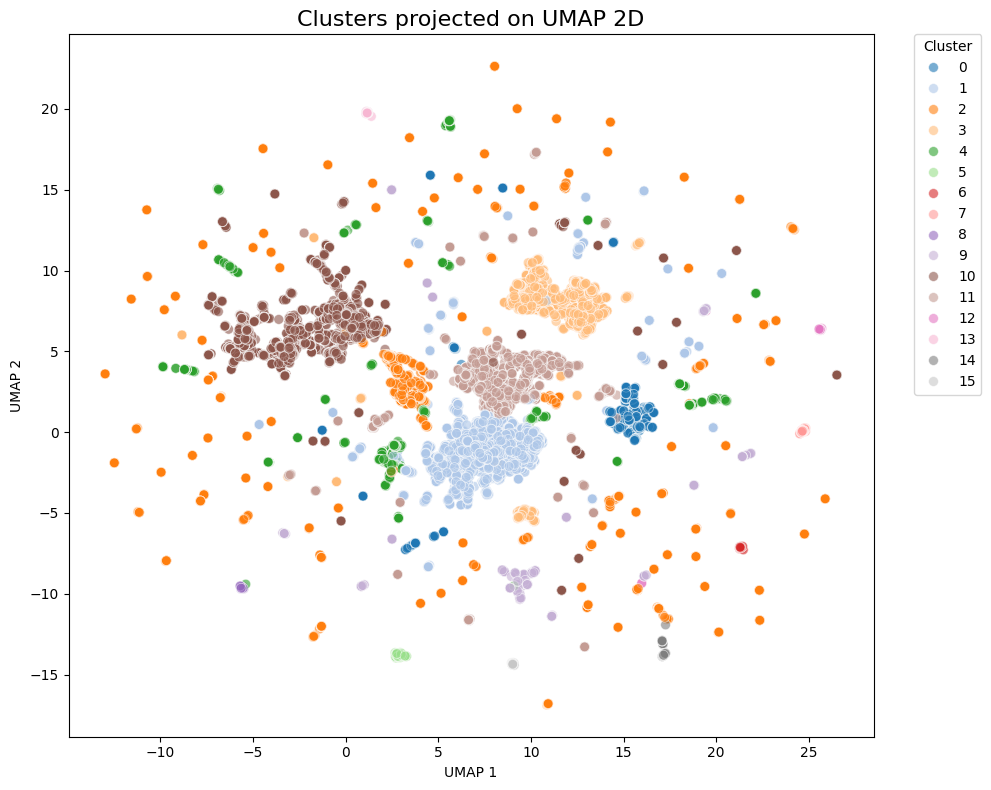

In [ ]:

X_umap_2d, _ = reduce_dimensions_umap(cluster_df_dist_cats_emb, n_components=2, random_state=42)



plt.figure(figsize=(10,8))

sns.scatterplot(
    x=X_umap_2d[:,0],
    y=X_umap_2d[:,1],
    hue=labels,
    palette='tab20',
    alpha=0.6,
    s=50
)


plt.title("Clusters projected on UMAP 2D", fontsize=16)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()




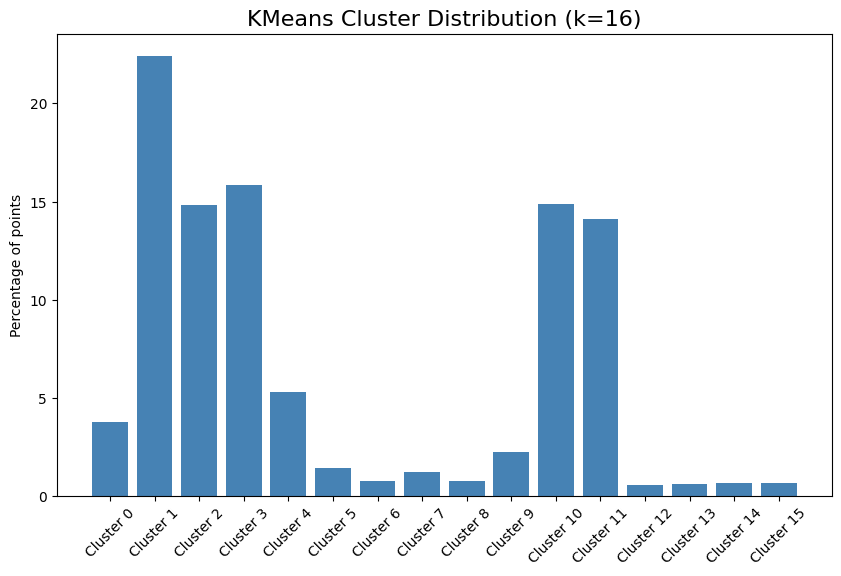

In [87]:
cluster_counts = pd.Series(labels).value_counts().sort_index()
cluster_percent = 100 * cluster_counts / cluster_counts.sum()

plt.figure(figsize=(10,6))
plt.bar(range(len(cluster_percent)), cluster_percent, color='steelblue')
plt.xticks(range(len(cluster_percent)), [f"Cluster {i}" for i in cluster_percent.index], rotation=45)
plt.ylabel("Percentage of points")
plt.title(f"KMeans Cluster Distribution (k={best_k_val})", fontsize=16)
plt.show()

In [80]:
# save a dataframe for predictions
df_rec = cluster_df_dist_cats_meta.copy()
df_rec['cluster_id'] = labels

# Make Recommendations

In [ ]:
# print("Scenario 1: Healthier alternatives exist within the dataset and cluster")
# print(recommend_alternates(df_rec, product_name="3 tomato pasta salad", product_nova=4, topN=3, isSameCluster=True))
# print(f"\n")

# print("Scenario 2: User selected a minimally processed food item (NOVA=1)")
# print(recommend_alternates(df_rec, product_name="Angel hair enriched macaroni product", product_nova=1, topN=3, isSameCluster=True))
# print(f"\n")

# print("Scenario 3: No less processed alternative available in dataset/clusterr")
# print(recommend_alternates(df_rec, product_name="Chicago style mix caramel corn", product_nova=4, topN=3, isSameCluster=True))
# print(f"\n")

Scenario 1: Healthier alternatives exist within the dataset and cluster
[('Greener selection', 1), ('GARDEN SALAD', 1), ('Very veggie romaine lettuce, iceberg lettuce, carrots, red cabbage, pea pods, radishes', 1)]


Scenario 2: User selected a minimally processed food item (NOVA=1)
['You have a very least-processed food but here is an alternate:', ('Spaghetti, enriched macaroni product, traditional', 1), ('Thin spaghetti, enriched macaroni product, traditional', 1), ('Angel hair, enriched macaroni product, traditional', 1)]


Scenario 3: No less processed alternative available in dataset/clusterr
Sorry, we couldn't find any suitable alternates. We'll work on improving our recommendations!




In [20]:
demo_df = pd.read_csv("../data/analysis_data/demo_data.csv", index_col=0)
avl_prod_names = demo_df['product_name'].values
temp_df = pd.read_csv("../data/analysis_data/kmeans_output_final.csv")
user_choice = np.random.choice(len(avl_prod_names))
user_choice_product = demo_df[demo_df['product_name'] == avl_prod_names[user_choice]]['product_name'].values[0]
user_choice_nova = demo_df[demo_df['product_name'] == avl_prod_names[user_choice]]['nova_group'].values[0]





In [21]:
print(user_choice_product)
print(user_choice_nova)
recommend_alternates(user_choice_product, user_choice_nova)

Organic Traditional Whole Wheat Lomein
3
[fetch_user_product_details] Time taken: 0.0102s
Mon Dec 22 13:37:16 2025 Building and compiling search function


Epochs completed: 100%| ██████████ 100/100 [00:00]


	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
[predict_cluster] Model load time: 1.0638s
[predict_cluster] Prediction time: 0.0242s
[predict_cluster] Total time: 1.0881s
[loading cluster outputs] Time taken: 0.4415s
[cleaning categories] Time taken: 0.2446s


[('Spaghetti, Whole Wheat Macaroni Product', 1),
 ('Fusilloni, Artisanal Bronze Die Pasta', 1),
 ('Conchiglioni Artisanal Pasta Bronze Die', 1)]